In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
from google.colab.patches import cv2_imshow
from tensorflow.keras import backend as K

import json
import numpy as np
from skimage.draw import polygon
import cv2 as cv
import os 
import shutil
import matplotlib
from google.colab import files

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
!unzip gdrive/My\ Drive/ID_card_thesis/midv_2020.zip

Archive:  gdrive/My Drive/ID_card_thesis/midv_2020.zip
   creating: tmask/
   creating: tmask/photo/
   creating: tmask/photo/annotations/
  inflating: tmask/photo/annotations/alb_id.json  
  inflating: tmask/photo/annotations/esp_id.json  
   creating: tmask/photo/images/
   creating: tmask/photo/images/alb_id/
  inflating: tmask/photo/images/alb_id/00.jpg  
  inflating: tmask/photo/images/alb_id/01.jpg  
  inflating: tmask/photo/images/alb_id/02.jpg  
  inflating: tmask/photo/images/alb_id/03.jpg  
  inflating: tmask/photo/images/alb_id/04.jpg  
  inflating: tmask/photo/images/alb_id/05.jpg  
  inflating: tmask/photo/images/alb_id/06.jpg  
  inflating: tmask/photo/images/alb_id/07.jpg  
  inflating: tmask/photo/images/alb_id/08.jpg  
  inflating: tmask/photo/images/alb_id/09.jpg  
  inflating: tmask/photo/images/alb_id/10.jpg  
  inflating: tmask/photo/images/alb_id/11.jpg  
  inflating: tmask/photo/images/alb_id/12.jpg  
  inflating: tmask/photo/images/alb_id/13.jpg  
  inflating: t

In [ ]:
# reads the json file with the annotations of id cards
def read_annotations_file(json_file):
  try:
      with open(json_file, "r") as read_file:
        data = json.load(read_file)
        return data
  except FileNotFoundError:
    print(f"No such file or directory exists: '{json_file}'")
    return None

# retrieves the image name, and the coordinates of id card position in the image
def retrieve_image_attributes(json_file):
    
    # data contains the json data read from the json file
    data = read_annotations_file(json_file)
    
    if(data):
        image_attributes_list = []                            # list to contain attributes of all images in the json file
        image_metadata = data["_via_img_metadata"]           # metadata of image in which the coordinates are present  
        image_id_list = data["_via_image_id_list"]            # names of images in the metadata

        for img in image_id_list:

            file_name = image_metadata[img]['filename']                          # filename to which the ground truth image wil be stored
            regions = image_metadata[img]['regions']
            all_points_x = regions[1]['shape_attributes']['all_points_x']      # all x coordinates  
            all_points_y = regions[1]['shape_attributes']['all_points_y']      # all y coordinates
            image_attributes_list.append((file_name,all_points_x,all_points_y))   

        return image_attributes_list                                             # list of tuples containing (filename, x coordinates and y coordinates) for every image
    else:
        return None

In [ ]:
# creates groud truth mask from all_points_x and all_points_y of four cornres of ID card in the image
def ground_truth(y_len, x_len, row_arr, col_arr, write_file_name):
    img = np.zeros((y_len, x_len), dtype=np.uint8)
    r = np.array(row_arr)
    c = np.array(col_arr)
    rr, cc = polygon(r,c)
    img[rr,cc] = 255
    
    cv.imwrite(write_file_name, img)

In [ ]:
# creates a new directory 
def create_directory(file_path, new_directory):
    path = os.path.join(file_path, new_directory)
    os.mkdir(path)
    
    return path
# creates ground truth mask at the specified path given
def create_mask(file_path, file_name, img_height, img_width, all_points_y, all_points_x):

    write_file_path = os.path.join(file_path, file_name)
    ground_truth(img_height, img_width, all_points_y, all_points_x, write_file_path)

In [ ]:
PHOTO_HEIGHT = 4032                     # height of images in photos folder
PHOTO_WIDTH = 2268                      # width of images in photos folder

SCAN_HEIGHT = 3507                      # height of images in scanned_rotated and scanned_upright folder
SCAN_WIDTH = 2480                       # width of images in  scanned_rotated and scanned_upright folder

PATH_PREFIX = 'tmask'                   # name of the folder containing the dataset

path_suffix = ["annotations/alb_id.json", "annotations/esp_id.json"]
id_class = ["alb_id", "esp_id"]



type_path = ["photo", "scan_rotated", "scan_upright"]

# creates ground truth mask for Albanian and Spanish ID cards in the entire dataset
for fol in type_path:
    mask_dir = create_directory(os.path.join(PATH_PREFIX, fol), "masks")
    for i in range(len(path_suffix)):
        image_attribute_list = retrieve_image_attributes(os.path.join(PATH_PREFIX, fol, path_suffix[i]))
        id_path = create_directory(mask_dir, id_class[i])

        if image_attribute_list:
          for img in image_attribute_list:
              if(fol == "photo"):
                  create_mask(id_path, img[0], PHOTO_HEIGHT, PHOTO_WIDTH, img[2], img[1])
              else:
                  create_mask(id_path, img[0], SCAN_HEIGHT, SCAN_WIDTH, img[2], img[1])
        else:
          print('empty')

# approx 4 minute running time

In [ ]:
def create_final_dataset_folder(final_data_path):
  final_data_folder = final_data_path
  final_images_path = os.path.join(final_data_folder, "images")
  final_masks_path = os.path.join(final_data_folder, "masks")
  os.mkdir(final_data_folder)
  os.mkdir(final_images_path)
  os.mkdir(final_masks_path)

  return (final_images_path, final_masks_path)

In [ ]:
def use_single_type(final_data_path, orig_data_path):
  final_paths = create_final_dataset_folder(final_data_path)
  final_images_path = final_paths[0] 
  final_masks_path = final_paths[1] 

  orig_images_path = os.path.join(orig_data_path, 'images')
  orig_masks_path = os.path.join(orig_data_path, 'masks')

  final_img_num = 0

  for cls in id_class:
    tmp_img_path = os.path.join(orig_images_path, cls)
    tmp_msk_path = os.path.join(orig_masks_path, cls)

    max_iter = 0
    if len(os.listdir(tmp_img_path)) == len(os.listdir(tmp_msk_path)):
      max_iter = len(os.listdir(tmp_img_path))

    for i in range(max_iter):
      old_file_name = f"{i:02}"+str(".jpg")
      new_file_name = f"{final_img_num+i:02}"+str(".jpg")

      img_src_path = os.path.join(tmp_img_path, old_file_name)
      img_dst_path = os.path.join(final_images_path, new_file_name)
      shutil.copy(img_src_path, img_dst_path)

      msk_src_path = os.path.join(tmp_msk_path, old_file_name)
      msk_dst_path = os.path.join(final_masks_path, new_file_name)
      shutil.copy(msk_src_path, msk_dst_path)

    final_img_num += 100

In [ ]:
final_data_path = "data"
use_single_type(final_data_path, "tmask/photo")

In [ ]:
scan_up_data_path = "scan_up_data"
use_single_type(scan_up_data_path, "tmask/scan_upright")

In [ ]:
scan_rot_data_path = "scan_rot_data"
use_single_type(scan_rot_data_path, "tmask/scan_rotated")

In [ ]:
import os
image_names = os.listdir("data/images")
mask_names = os.listdir("data/masks")

In [ ]:
scan_up_img_names = os.listdir("scan_up_data/images/")
scan_up_msk_names = os.listdir("scan_up_data/masks/")

scan_rot_img_names = os.listdir("scan_rot_data/images/")
scan_rot_msk_names = os.listdir("scan_rot_data/masks/")

In [ ]:
image_names.sort()
mask_names.sort()

In [ ]:
scan_up_img_names.sort()
scan_up_msk_names.sort()

scan_rot_img_names.sort()
scan_rot_msk_names.sort()

In [ ]:
for i in range(1,200):
  if(image_names[i] != mask_names[i]):
    print(image_names[i])
    print(mask_names[i])
    print("------------------------")
  

In [ ]:
for i in range(1,200):
  if(scan_up_img_names[i] != scan_up_msk_names[i]):
    print(image_names[i])
    print(mask_names[i])
    print("------------------------")

In [ ]:
for i in range(1,200):
  if(scan_rot_img_names[i] != scan_rot_msk_names[i]):
    print(image_names[i])
    print(mask_names[i])
    print("------------------------")

In [ ]:
print(image_names[81])
print(mask_names[81])

164.jpg
164.jpg


In [ ]:
print(scan_up_img_names[81])
print(scan_up_msk_names[81])

164.jpg
164.jpg


In [ ]:
print(scan_rot_img_names[81])
print(scan_rot_msk_names[81])

164.jpg
164.jpg


In [ ]:
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(image_names, mask_names, test_size=0.2, random_state=42)

x_test, x_val, y_test, y_val = train_test_split(x_test, y_test, test_size=0.5, random_state=42) # 0.25 x 0.8 = 0.2

In [ ]:
print(len(x_train), len(y_train))

160 160


In [ ]:
print(len(x_val), len(y_val))

20 20


In [ ]:
print(len(x_test), len(y_test))

20 20


In [ ]:
x_train[0]

'162.jpg'

In [ ]:
x_val[0]

'152.jpg'

In [ ]:
256*2

512

In [ ]:
def read_images(image_list, image_path):
  temp_image_list = []
  for image in image_list:
    orig_img = cv.imread(os.path.join(image_path, image))
    res_img = cv.resize(orig_img, (256,256), interpolation=cv.INTER_NEAREST)/255
    temp_image_list.append(tf.constant(res_img))
  return temp_image_list

def read_masks(mask_list, mask_path):
  temp_mask_list = []
  for mask in mask_list:
    orig_msk = cv.imread(os.path.join(mask_path, mask),cv.IMREAD_GRAYSCALE)
    res_msk = cv.resize(orig_msk, (256,256), interpolation=cv.INTER_NEAREST)/255
    temp_mask_list.append(tf.constant(np.expand_dims(res_msk,axis=2)))
  return temp_mask_list

In [ ]:
train_images = read_images(x_train, "data/images")
train_masks = read_masks(y_train, "data/masks")
val_images = read_images(x_val, "data/images")
val_masks = read_masks(y_val, "data/masks")
test_images = read_images(x_test, "data/images")
test_masks = read_masks(y_test, "data/masks")

# approx 45s

In [ ]:
scan_up_test_images = read_images(scan_up_img_names, "scan_up_data/images")
scan_up_test_masks = read_masks(scan_up_msk_names, "scan_up_data/masks")

scan_rot_test_images = read_images(scan_rot_img_names, "scan_rot_data/images")
scan_rot_test_masks = read_masks(scan_rot_img_names, "scan_rot_data/masks")

In [ ]:
len(train_images)

160

In [ ]:
len(train_masks)

160

In [ ]:
len(val_images)

20

In [ ]:
len(val_masks)

20

In [ ]:
len(test_images)

20

In [ ]:
len(test_masks)

20

In [ ]:
train_dataset = tf.data.Dataset.from_tensor_slices((train_images, train_masks))
val_dataset = tf.data.Dataset.from_tensor_slices((val_images, val_masks))
test_dataset = tf.data.Dataset.from_tensor_slices((test_images, test_masks))

In [ ]:
scan_up_test_dataset = tf.data.Dataset.from_tensor_slices((scan_up_test_images, scan_up_test_masks))
scan_rot_test_dataset = tf.data.Dataset.from_tensor_slices((scan_rot_test_images, scan_rot_test_masks))

In [ ]:
BATCH_SIZE = 16
train_batches = train_dataset.batch(BATCH_SIZE).repeat()
train_batches = train_batches.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
val_batches = val_dataset.batch(BATCH_SIZE).repeat()
val_batches = val_batches.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

In [ ]:
# test_batches = test_dataset.batch(BATCH_SIZE).repeat()
# test_batches = test_batches.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

In [ ]:
test_batches = test_dataset.batch(BATCH_SIZE)

In [ ]:
scan_up_test_batches =  scan_up_test_dataset.batch(BATCH_SIZE)

In [ ]:
scan_rot_test_batches =  scan_rot_test_dataset.batch(BATCH_SIZE)

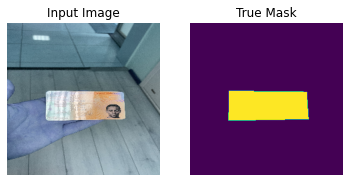

In [ ]:
def display(display_list):
 plt.figure()

 title = ["Input Image", "True Mask", "Predicted Mask"]

 for i in range(len(display_list)):
   plt.subplot(1, len(display_list), i+1)
   plt.title(title[i])
   plt.imshow(tf.keras.utils.array_to_img(display_list[i]))
   plt.axis("off")
 plt.show()

sample_batch = next(iter(train_batches))
random_index = np.random.choice(sample_batch[0].shape[0])
sample_image, sample_mask = sample_batch[0][random_index], sample_batch[1][random_index]
display([sample_image, sample_mask])

In [ ]:
def double_conv_block(x, n_filters):

   # Conv2D then ReLU activation
   x = layers.Conv2D(n_filters, 3, padding = "same", activation = "relu", kernel_initializer = "he_normal")(x)
   # Conv2D then ReLU activation
   x = layers.Conv2D(n_filters, 3, padding = "same", activation = "relu", kernel_initializer = "he_normal")(x)

   return x

In [ ]:
def downsample_block(x, n_filters):
   f = double_conv_block(x, n_filters)
   p = layers.MaxPool2D(2)(f)
   p = layers.Dropout(0.3)(p)

   return f, p

In [ ]:
def upsample_block(x, conv_features, n_filters):
   # upsample
   x = layers.Conv2DTranspose(n_filters, 3, 2, padding="same")(x)
   # concatenate
   x = layers.concatenate([x, conv_features])
   # dropout
   x = layers.Dropout(0.3)(x)
   # Conv2D twice with ReLU activation
   x = double_conv_block(x, n_filters)

   return x

In [ ]:
def build_unet_model():
  # inputs
  inputs = layers.Input(shape=(256,256,3))

  f1, p1 = downsample_block(inputs, 64)
  f2, p2 = downsample_block(p1, 128)
  f3, p3 = downsample_block(p2, 256)

  bottleneck = double_conv_block(p3, 512)

  u6 = upsample_block(bottleneck, f3, 256)
  u7 = upsample_block(u6, f2, 128)
  u8 = upsample_block(u7, f1, 64)

  outputs = layers.Conv2D(1, 1, padding="same",activation='sigmoid')(u8)

  # unet model with Keras Functional API
  unet_model = tf.keras.Model(inputs, outputs, name="U-Net")

  return unet_model

In [ ]:
unet_model = build_unet_model()

In [ ]:
unet_model.compile(optimizer=tf.keras.optimizers.Adam(),
                  loss="binary_crossentropy",
                  metrics=['accuracy'])

In [ ]:
unet_model.summary()

Model: "U-Net"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 256, 256, 64  1792        ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 conv2d_1 (Conv2D)              (None, 256, 256, 64  36928       ['conv2d[0][0]']                 
                                )                                                             

In [ ]:
len(train_dataset)

160

In [ ]:
def MyCallback():
  checkpointer = tf.keras.callbacks.ModelCheckpoint(filepath='unet.h5', verbose=0, save_best_only=True, save_weights_only=True)
  callbacks = [checkpointer]
  return callbacks


In [ ]:
NUM_EPOCHS = 60

TRAIN_LENGTH = len(train_dataset)
STEPS_PER_EPOCH = TRAIN_LENGTH // BATCH_SIZE

# VAL_SUBSPLITS = 5
TEST_LENTH = len(val_dataset)
# VALIDATION_STEPS = TEST_LENTH // BATCH_SIZE // VAL_SUBSPLITS
VALIDATION_STEPS = TEST_LENTH // BATCH_SIZE 

model_history = unet_model.fit(train_batches,
                              epochs=NUM_EPOCHS,
                              steps_per_epoch=STEPS_PER_EPOCH,
                              validation_steps=VALIDATION_STEPS,
                              validation_data=val_batches,
                               callbacks=[MyCallback()])

Epoch 1/60
10/10 [==============================] - 17s 447ms/step - loss: 0.7093 - accuracy: 0.8331 - val_loss: 0.4244 - val_accuracy: 0.8581
Epoch 2/60
10/10 [==============================] - 4s 418ms/step - loss: 0.4111 - accuracy: 0.8763 - val_loss: 0.3282 - val_accuracy: 0.8903
Epoch 3/60
10/10 [==============================] - 4s 419ms/step - loss: 0.3787 - accuracy: 0.8899 - val_loss: 0.3202 - val_accuracy: 0.8922
Epoch 4/60
10/10 [==============================] - 4s 419ms/step - loss: 0.3316 - accuracy: 0.8945 - val_loss: 0.2804 - val_accuracy: 0.9094
Epoch 5/60
10/10 [==============================] - 4s 419ms/step - loss: 0.2988 - accuracy: 0.8958 - val_loss: 0.2626 - val_accuracy: 0.9061
Epoch 6/60
10/10 [==============================] - 4s 417ms/step - loss: 0.2837 - accuracy: 0.8982 - val_loss: 0.2612 - val_accuracy: 0.9007
Epoch 7/60
10/10 [==============================] - 4s 417ms/step - loss: 0.2760 - accuracy: 0.8982 - val_loss: 0.2508 - val_accuracy: 0.9027
Epoch

In [ ]:
# pred = unet_model.predict(x=test_batches,
#                           steps=PREDICTION_STEPS, verbose=0)

In [ ]:
# pred.shape

In [ ]:
# scan_up_pred = unet_model.predict(x=scan_up_test_batches,
#                            steps=PREDICTION_STEPS, verbose=0)

In [ ]:
# for i in scan_up_test_batches:
#   print(i)
#   break

In [ ]:
# def pred_single_batch(predictions, test_batch):
#   for batch in test_batch:
#     first_batch = batch
#     break
#   true_images = first_batch[0]
#   true_masks = first_batch[1]

#   curr_iter = 0
#   max_imgs = 20
#   all_images = []
#   # res_path = create_directory('/content/','prediction')
#   for true_img, true_msk, pred_msk in zip(true_images, true_masks, predictions):
#     comparison = []
#     img = np.squeeze(true_img).copy()*255
#     msk = np.squeeze(true_msk).copy()*255
#     msk = np.stack((msk,)*3, axis=-1)
#     res = pred_msk.copy()
#     res = res[:,:,0]
#     res[res >= 0.9] = 255
#     res[res < 0.9] = 0
#     res = np.stack((res,)*3, axis=-1)
#     comparison = np.concatenate((img,msk,res), axis=1)
#     cv2_imshow(comparison)

#     # temp_comparison = comparison.copy()
#     # temp_comparison = temp_comparison.astype(int)
#     # temp_comparison = np.uint8(temp_comparison)

#     # img_write = os.path.join(res_path,f'{curr_iter}.png')
#     # matplotlib.image.imsave(img_write, temp_comparison)
#     # files.download(img_write)
#     curr_iter += 1
#     if curr_iter == 20:
#       break

In [ ]:
import matplotlib
from google.colab import files

def pred_masks(predict_dataset, predict_batch, is_full_batches):
  
  predict_length = len(predict_dataset)
  predict_steps = predict_length // BATCH_SIZE 
 
  for batch in predict_batch:
    predictions = unet_model.predict(x=batch[0],
                          steps=predict_steps, verbose=0)
    first_batch = batch
    
    true_images = first_batch[0]
    true_masks = first_batch[1]

    all_images = []
    # res_path = createDirectory('/content/','prediction')
    for true_img, true_msk, pred_msk in zip(true_images, true_masks, predictions):
      comparison = []
      img = np.squeeze(true_img).copy()*255
      msk = np.squeeze(true_msk).copy()*255
      msk = np.stack((msk,)*3, axis=-1)
      res = pred_msk.copy()
      res = res[:,:,0]
      res[res >= 0.9] = 255
      res[res < 0.9] = 0
      res = np.stack((res,)*3, axis=-1)
      comparison = np.concatenate((img,msk,res), axis=1)
      cv2_imshow(comparison)

      # temp_comparison = comparison.copy()
      # temp_comparison = temp_comparison.astype(int)
      # temp_comparison = np.uint8(temp_comparison)

      # img_write = os.path.join(res_path,f'{curr_iter}.png')
      # matplotlib.image.imsave(img_write, temp_comparison)
      # files.download(img_write)
    if not is_full_batches:
      break

In [ ]:
pred_masks(test_dataset, test_batches, True)

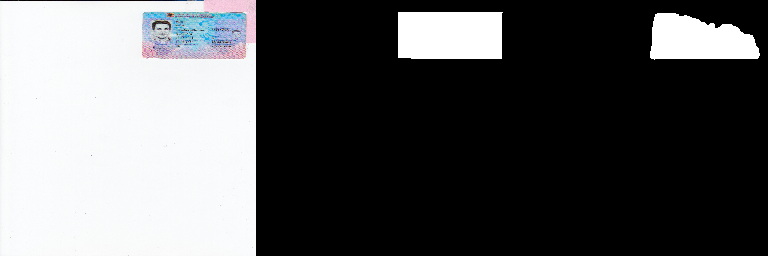

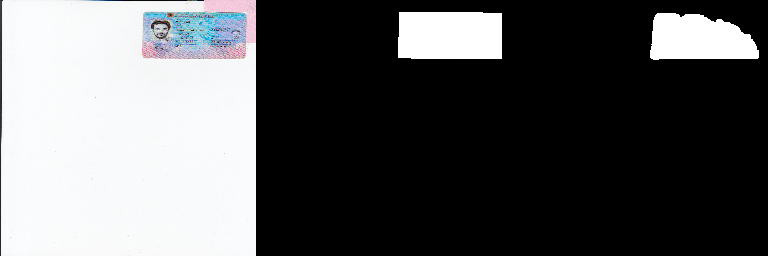

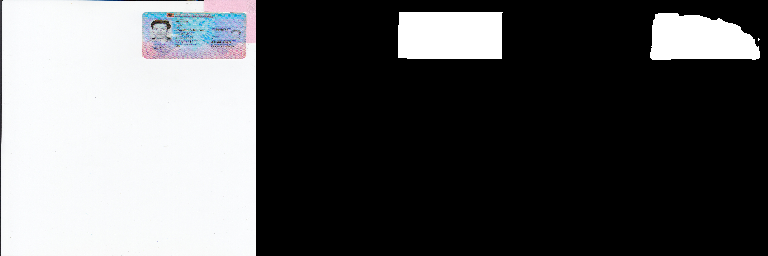

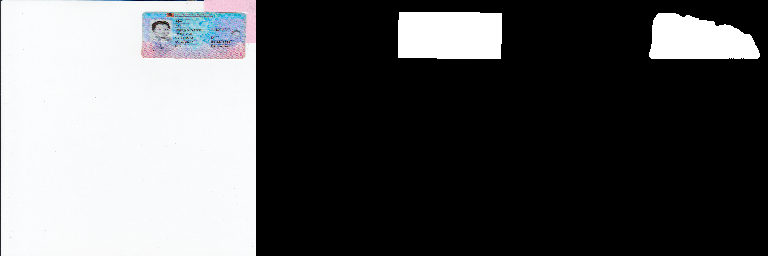

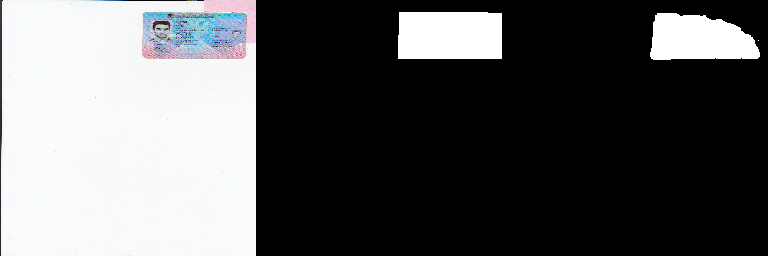

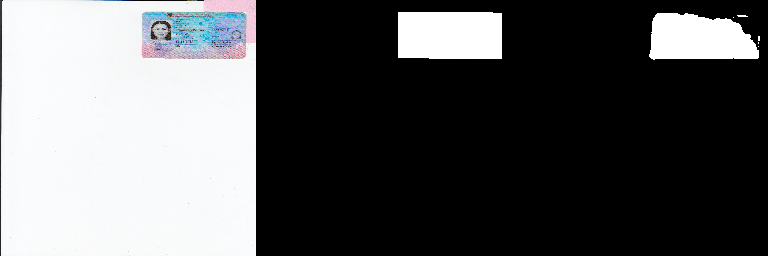

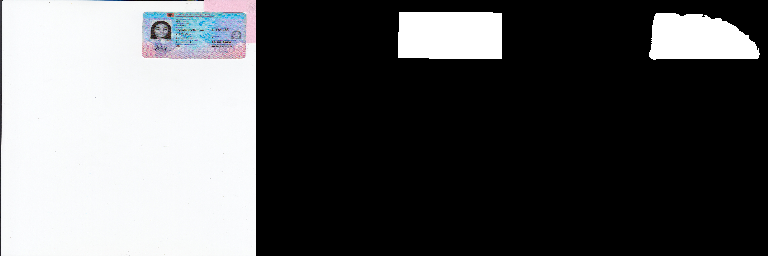

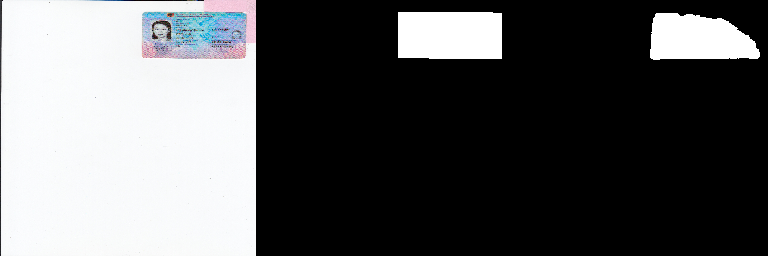

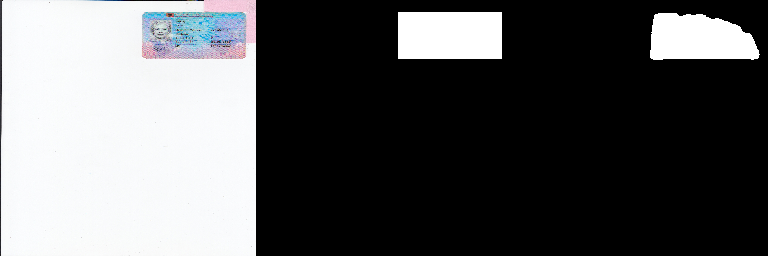

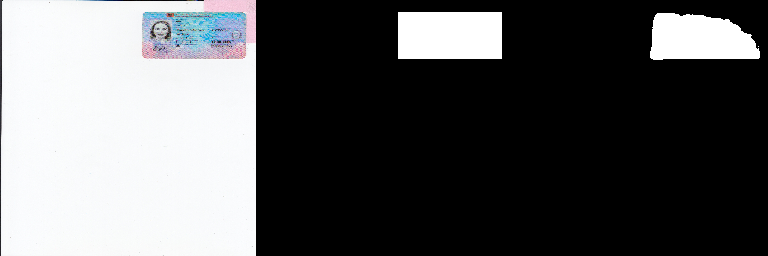

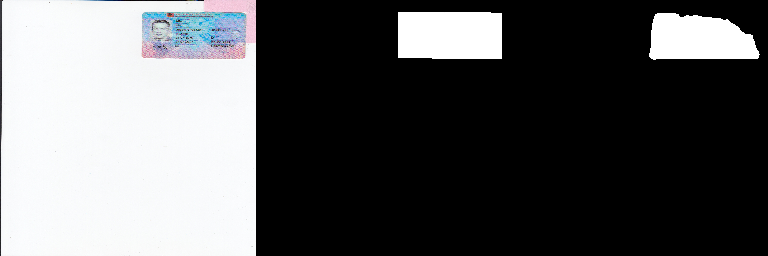

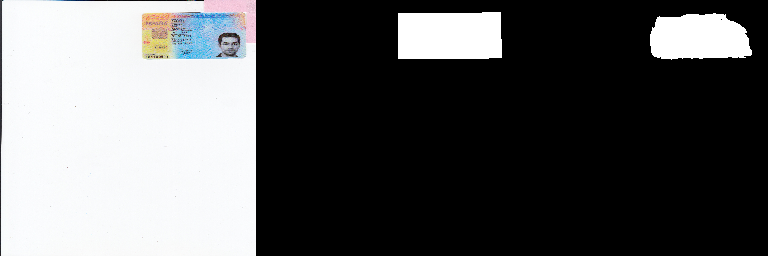

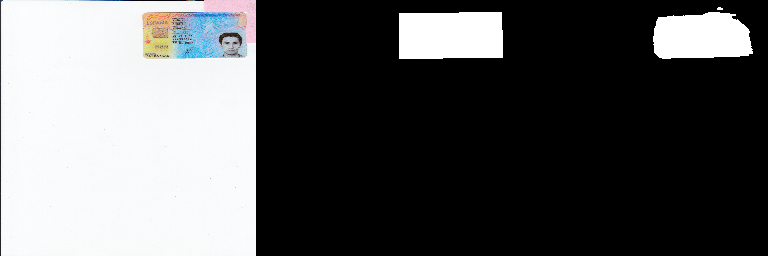

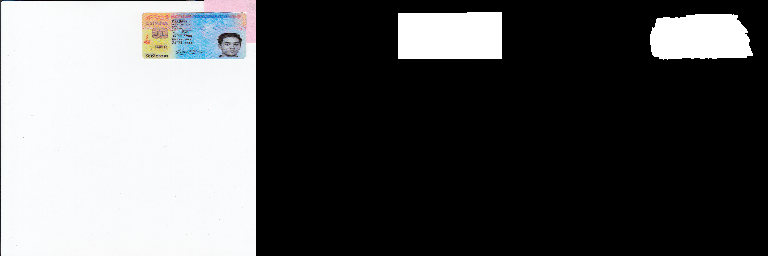

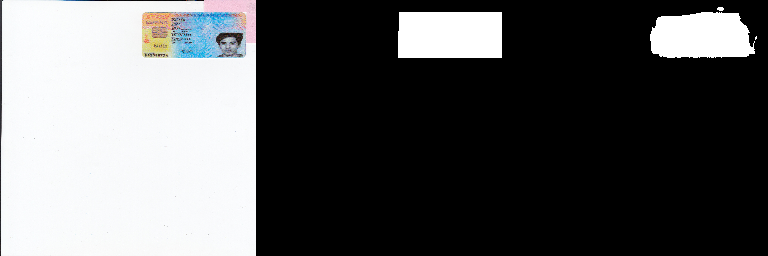

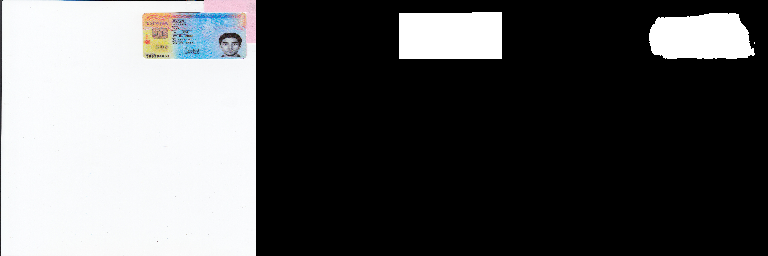

In [ ]:
pred_masks(scan_up_test_dataset, scan_up_test_batches, False)

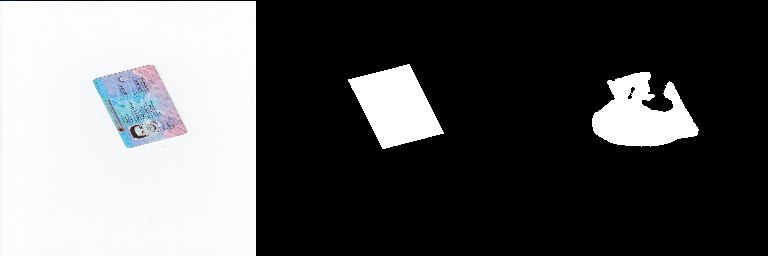

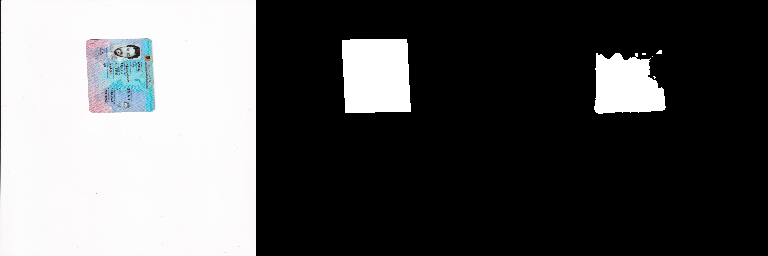

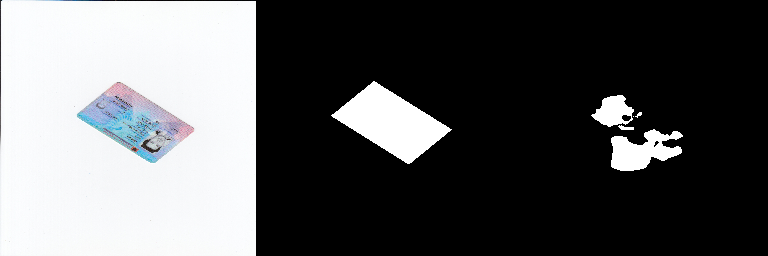

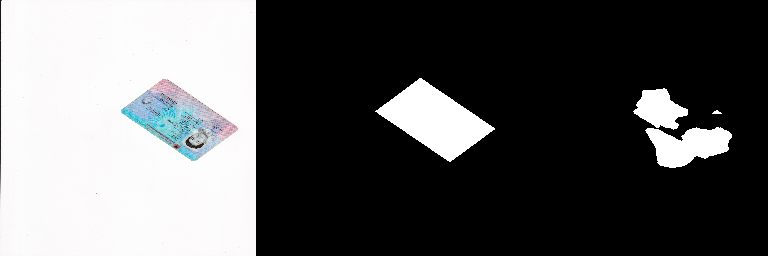

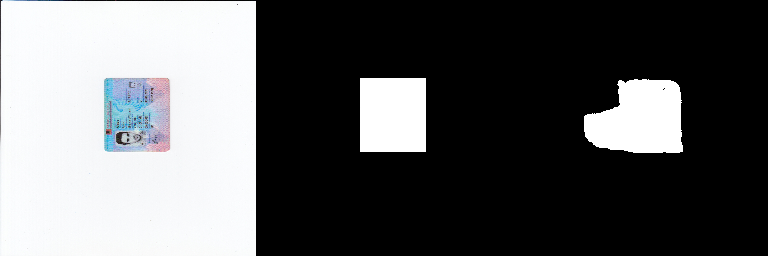

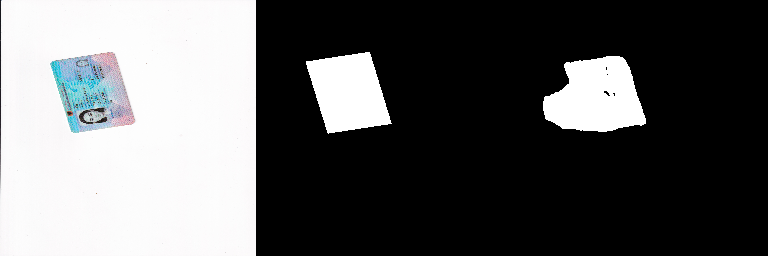

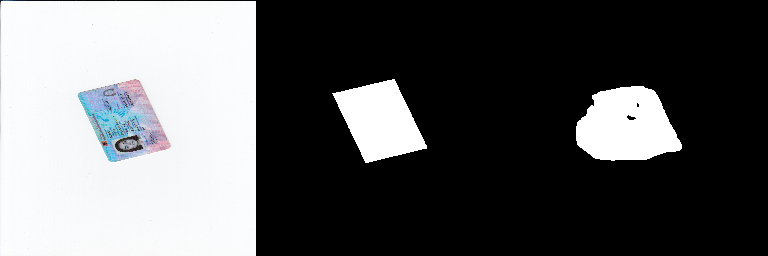

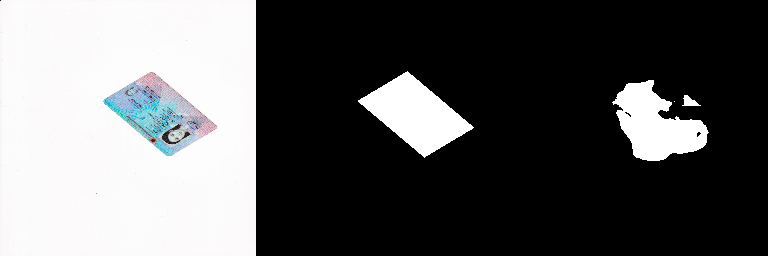

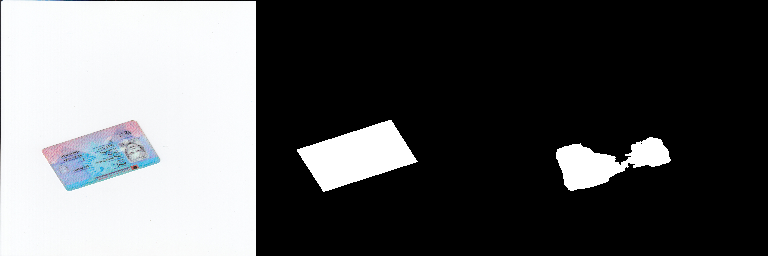

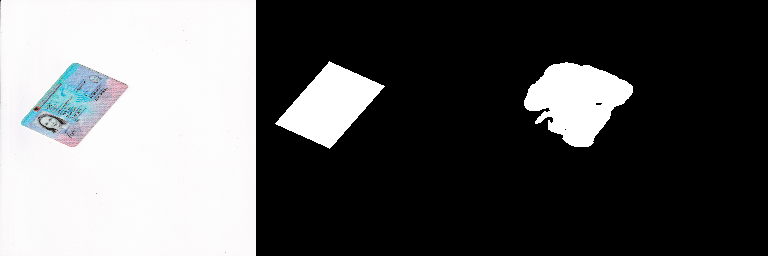

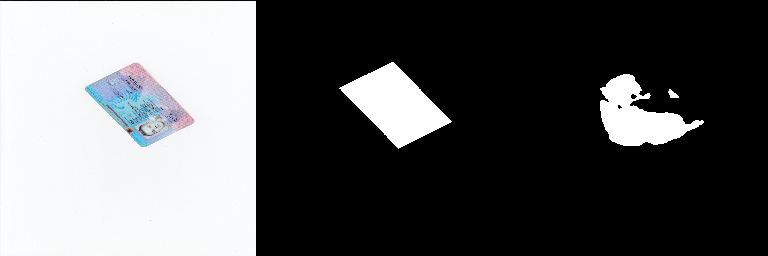

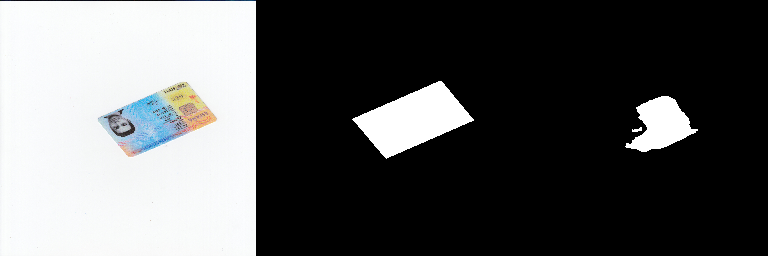

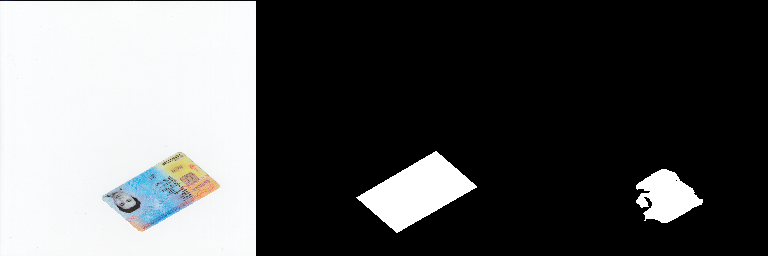

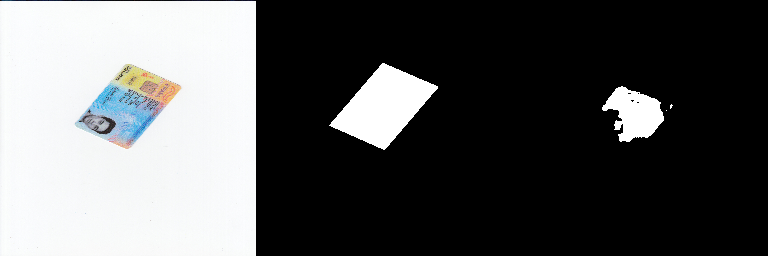

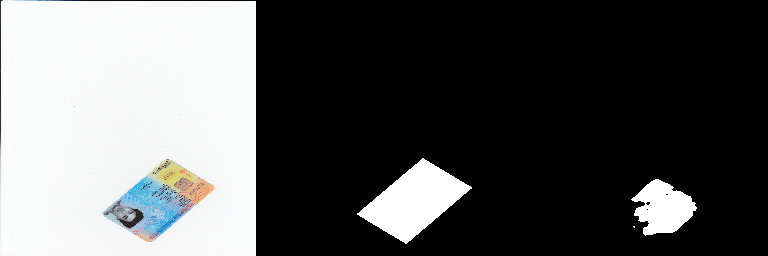

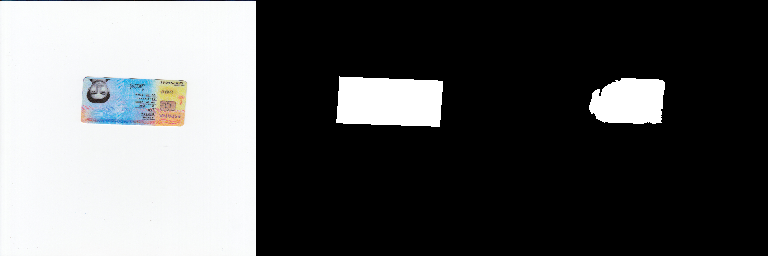

In [ ]:
pred_masks(scan_rot_test_dataset, scan_rot_test_batches, False)

In [ ]:
mystr = '00.jpg'

In [ ]:
lst = mystr.split('.')[0]

In [ ]:
lst

'00'

In [ ]:
int(mystr.split('.')[0])

0